In [1]:
from chessnet.notebook_config import *

from chessnet.graphs import  read_degree_and_elo
from chessnet.rich_club import read_rich_club, read_rich_club_elo

In [2]:
node_dfs = {
    "OTB": read_degree_and_elo(Database.OTB),
    "Portal": read_degree_and_elo(Database.Portal),
}

In [3]:
def get_elo_vs_k(node_df):
    X = np.logspace(1, np.log10(max(node_df.k)+1), 20).astype(int)
    mean_values = []
    std_values = []
    for i in range(len(X)-1):
        mink, maxk = X[i], X[i+1]
        elos = node_df[(mink <= node_df.k) & (node_df.k < maxk)].MeanElo
        mean_values.append(elos.mean())
        std_values.append(elos.std())
    return X, mean_values, std_values

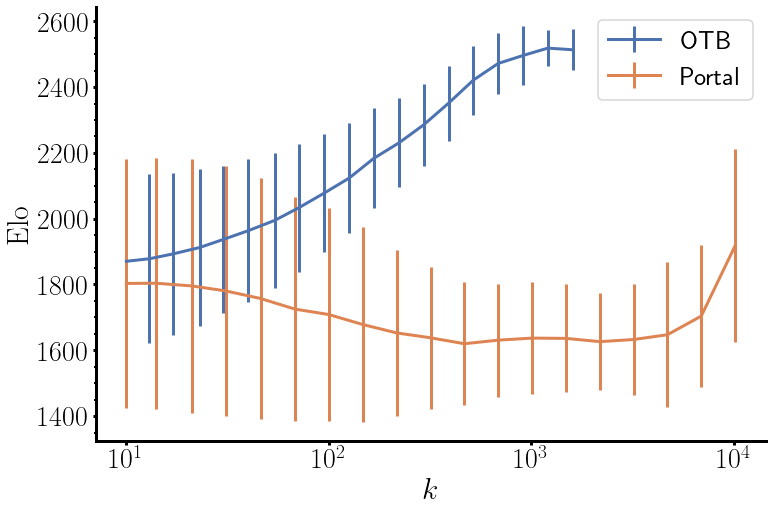

In [4]:
fig, ax = plt.subplots()
ax.set_xlabel(r"$k$")
ax.set_ylabel(r"$\mathrm{Elo}$")
ax.set_xscale("log")
for name, node_df in node_dfs.items():
    X, mean_values, std_values = get_elo_vs_k(node_df)
    ax.errorbar(X[:-1], mean_values, std_values, label=name)
ax.legend()
sns.despine()
plt.show()

In [5]:
samples = 100
rich_club_data = {
    "OTB": read_rich_club("OM_OTB_201609", samples=samples),
    "Portal": read_rich_club("OM_Portal_201510", samples=samples)
}
rich_club_elo_data = {
    "OTB": read_rich_club_elo("OM_OTB_201609", samples=samples),
    "Portal": read_rich_club_elo("OM_Portal_201510", samples=samples)
} 

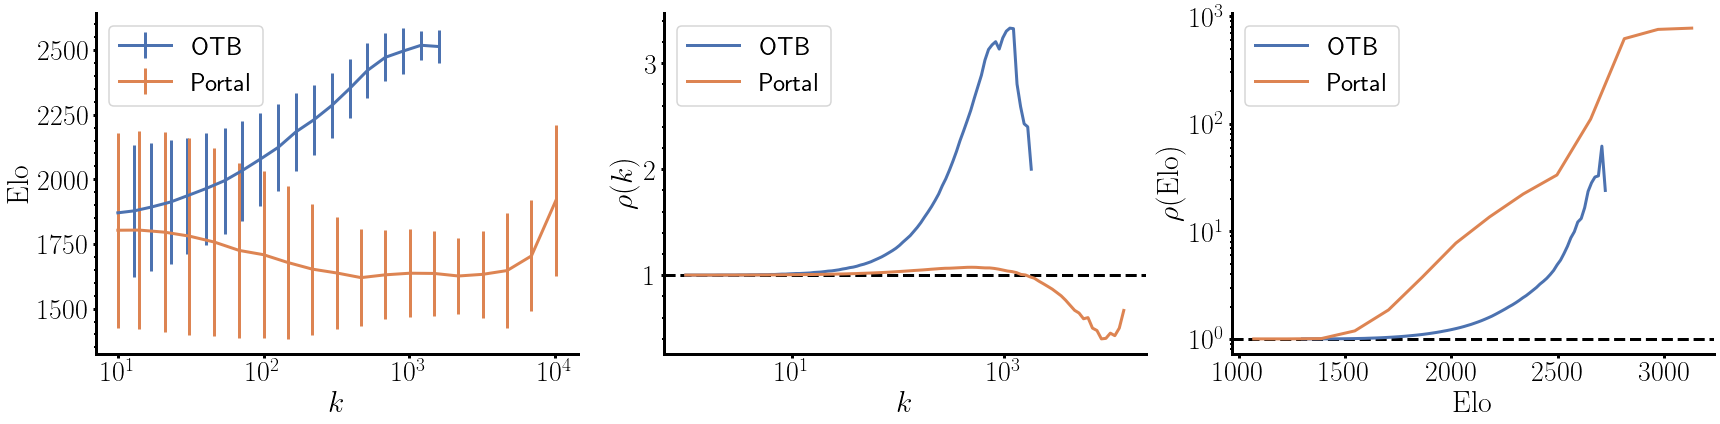

In [6]:
ncols, nrows = 3, 1
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

ax = axes[0]
ax.set_xlabel(r"$k$")
ax.set_ylabel(r"$\mathrm{Elo}$")
ax.set_xscale("log")
for name, node_df in node_dfs.items():
    X, mean_values, std_values = get_elo_vs_k(node_df)
    ax.errorbar(X[:-1], mean_values, std_values, label=name)

ax = axes[1]
ax.set_xscale("log")
ax.set_xlabel(r"$k$")
ax.set_ylabel(r"$\rho(k)$")
ax.axhline(1, color="k", linestyle="--")
for name, df in rich_club_data.items():
    ax.plot(df.k, df.rho, label=name)

ax = axes[2]
ax.set_yscale("log")
ax.set_xlabel(r"$\mathrm{Elo}$")
ax.set_ylabel(r"$\rho(\mathrm{Elo})$")
ax.axhline(1, color="k", linestyle="--")
for name, df in rich_club_elo_data.items():
    ax.plot(df.elo, df.rho, label=name)

for ax in axes:
    ax.legend()

sns.despine()

plt.tight_layout()
plt.show()

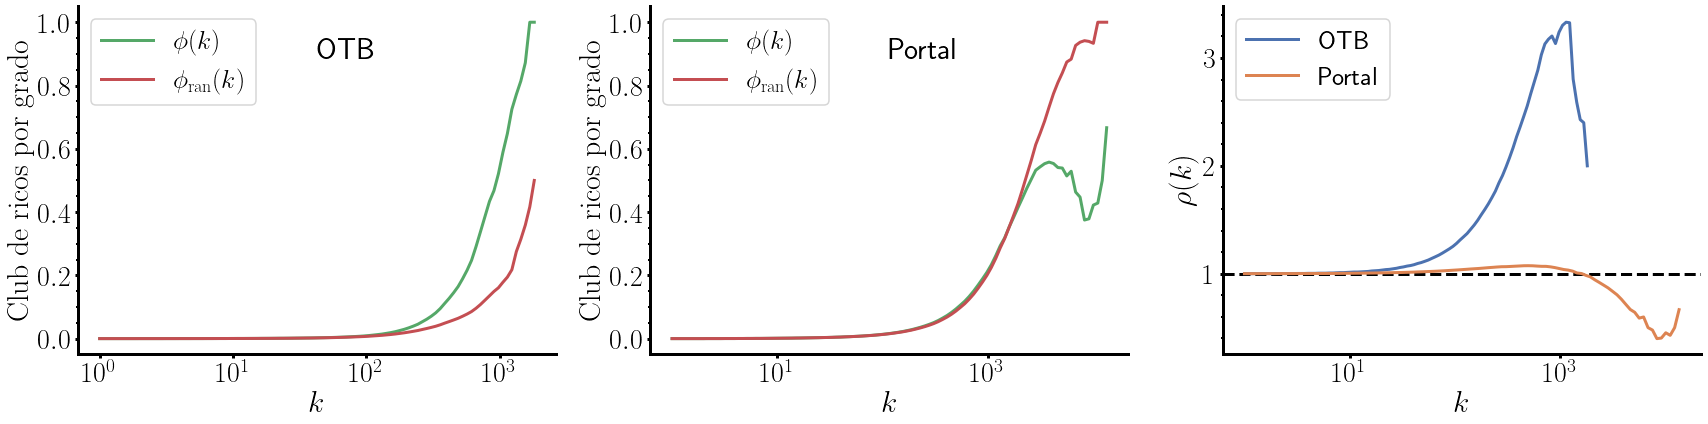

In [7]:
ncols, nrows = 3, 1
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

for i, (name, df) in enumerate(rich_club_data.items()):
    ax = axes[i]
    ax.set_xlabel(r"$k$")
    ax.set_ylabel(r"$\mathrm{Club\;de\;ricos\;por\;grado}$")
    ax.set_xscale("log")
    ax.plot(df.k, df.phi, label=r"$\phi(k)$", color="C2")
    ax.plot(df.k, df.rand_phi, label=r"$\phi_{\mathrm{ran}}(k)$", color="C3")
    ax.text(0.5, 0.85, name, transform=ax.transAxes, fontsize=30)
    ax.legend()

ax = axes[2]
ax.set_xscale("log")
ax.set_xlabel(r"$k$")
ax.set_ylabel(r"$\rho(k)$")
ax.axhline(1, color="k", linestyle="--")
for name, df in rich_club_data.items():
    ax.plot(df.k, df.rho, label=name)
ax.legend()
sns.despine()
plt.tight_layout()
plt.show()

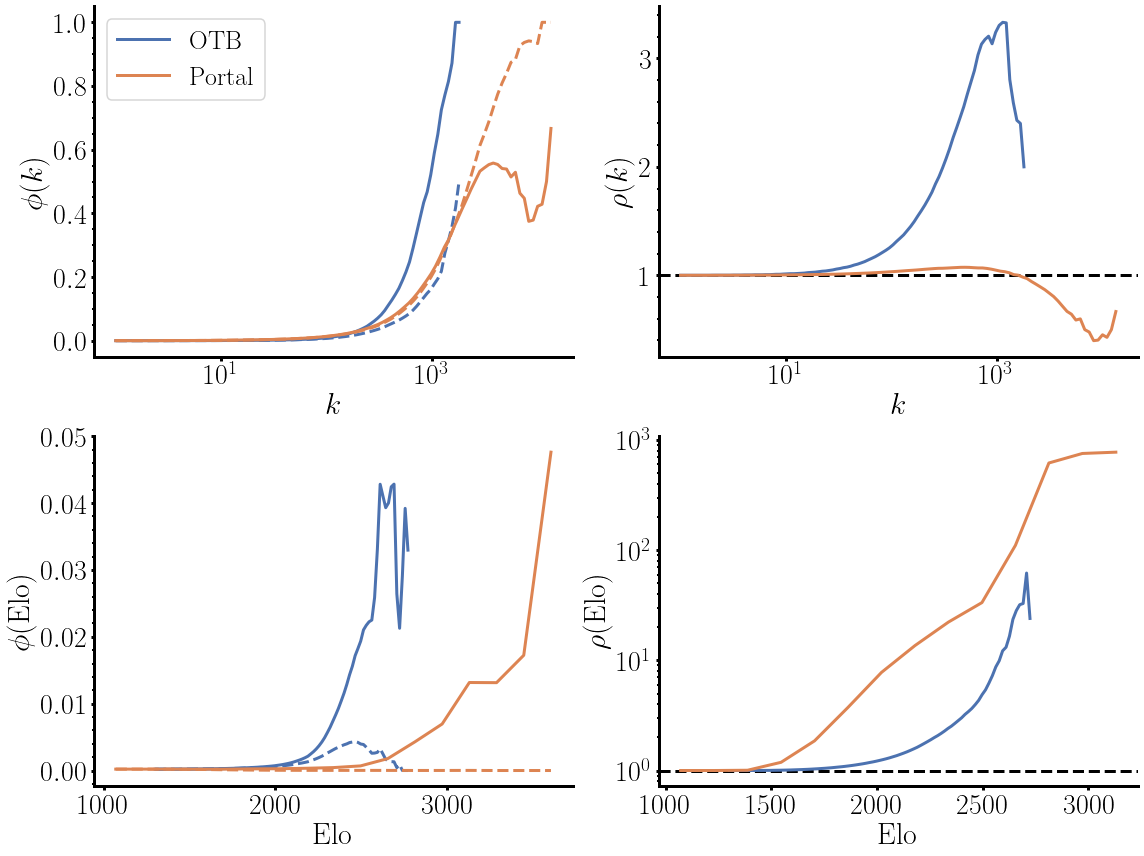

In [11]:
ncols, nrows = 2, 2
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

for i, (name, df) in enumerate(rich_club_data.items()):
    ax = axes[0,0]
    ax.set_xlabel(r"$k$")
    ax.set_ylabel(r"$\phi(k)$")
    ax.set_xscale("log")
    ax.plot(df.k, df.phi, label=database_latex[name], color=f"C{i}")
    ax.plot(df.k, df.rand_phi,  color=f"C{i}", linestyle="--")
    ax.legend()

ax = axes[0,1]
ax.set_xscale("log")
ax.set_xlabel(r"$k$")
ax.set_ylabel(r"$\rho(k)$")
ax.axhline(1, color="k", linestyle="--")
for name, df in rich_club_data.items():
    ax.plot(df.k, df.rho, label=database_latex[name])


for i, (name, df) in enumerate(rich_club_elo_data.items()):
    ax = axes[1,0]
    ax.set_xlabel(r"$\mathrm{Elo}$")
    ax.set_ylabel(r"$\phi(\mathrm{Elo})$")
    #ax.set_yscale("log")
    df = df.dropna()
    ax.plot(df.elo.values[:-1], df.phi.values[:-1], label=database_latex[name], color=f"C{i}")
    ax.plot(df.elo.values[:-1], df.rand_phi.values[:-1],  color=f"C{i}", linestyle="--")



ax = axes[1,1]
ax.set_yscale("log")
ax.set_xlabel(r"$\mathrm{Elo}$")
ax.set_ylabel(r"$\rho(\mathrm{Elo})$")
ax.axhline(1, color="k", linestyle="--")
for name, df in rich_club_elo_data.items():
    ax.plot(df.elo, df.rho)

sns.despine()
plt.tight_layout()
plt.show()

In [10]:
df

,Unnamed: 0,elo,phi,rand_phi,rho
0,0,1070.750000,0.000207,0.000207,1.000000
1,1,1229.176768,0.000207,0.000207,1.000000
2,2,1387.603535,0.000203,0.000202,1.005960
3,3,1546.030303,0.000199,0.000168,1.187195
4,4,1704.457071,0.000205,0.000111,1.858879
...,...,...,...,...,...
95,95,16121.292929,NaN,NaN,NaN
96,96,16279.719697,NaN,NaN,NaN
97,97,16438.146465,NaN,NaN,NaN
98,98,16596.573232,NaN,NaN,NaN
